# 02 — Feature Engineering for Credit Risk Modeling

**Objective**: Transform raw loan data into predictive features for PD (Probability of Default) modeling using credit risk domain knowledge.

**Input**: `train.parquet` (1.35M loans, 110 raw columns) + `calibration.parquet` + `test.parquet`

**Approach**:
1. Clean & parse raw columns (int_rate %, term, emp_length)
2. Create financial ratios (loan-to-income, installment burden, etc.)
3. Create credit history features (FICO mid, credit age, delinquency flags)
4. Create behavioral / account features
5. WOE encoding with OptBinning (grade, purpose, home_ownership)
6. Information Value (IV) ranking for feature selection
7. Validate final feature set with Pandera schemas
8. Save modeling-ready datasets

**Key Principle**: Only use features available at **loan origination** — no post-loan variables (leakage).

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from pathlib import Path
from loguru import logger

from src.features.feature_engineering import (
    create_ratios, create_buckets, create_interactions,
    create_temporal_features, compute_woe
)
from src.features.schemas import loan_master_schema

sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)
plt.rcParams.update({"figure.figsize": (12, 6), "figure.dpi": 100})

DATA_DIR = Path("../data/processed")
print("Setup complete.")

Setup complete.


---
## 1. Load Raw Train Data

In [2]:
train_raw = pd.read_parquet(DATA_DIR / "train.parquet")
cal_raw = pd.read_parquet(DATA_DIR / "calibration.parquet")
test_raw = pd.read_parquet(DATA_DIR / "test.parquet")

print(f"Train:       {train_raw.shape[0]:>10,} rows x {train_raw.shape[1]} cols")
print(f"Calibration: {cal_raw.shape[0]:>10,} rows x {cal_raw.shape[1]} cols")
print(f"Test:        {test_raw.shape[0]:>10,} rows x {test_raw.shape[1]} cols")
print(f"\nDefault rates: Train={train_raw['default_flag'].mean():.2%}  "
      f"Cal={cal_raw['default_flag'].mean():.2%}  "
      f"Test={test_raw['default_flag'].mean():.2%}")

Train:        1,346,311 rows x 110 cols
Calibration:    237,584 rows x 110 cols
Test:           276,869 rows x 110 cols

Default rates: Train=18.52%  Cal=22.20%  Test=21.98%


---
## 2. Clean & Parse Raw Columns

Several columns arrive as strings and need numeric conversion:
- `int_rate`: "13.56%" → 13.56
- `term`: " 36 months" → 36
- `revol_util`: "55.3%" → 55.3
- `emp_length`: "10+ years" → 10

In [3]:
def clean_raw_columns(df):
    """Parse string columns to numeric types."""
    df = df.copy()

    # int_rate: "13.56%" -> 13.56
    if "int_rate" in df.columns and df["int_rate"].dtype == object:
        df["int_rate"] = (
            df["int_rate"].astype(str).str.strip().str.rstrip("%")
            .pipe(pd.to_numeric, errors="coerce")
        )

    # term: " 36 months" -> 36
    if "term" in df.columns and df["term"].dtype == object:
        df["term"] = (
            df["term"].astype(str).str.extract(r"(\d+)")[0]
            .pipe(pd.to_numeric, errors="coerce")
        )

    # revol_util: "55.3%" -> 55.3
    if "revol_util" in df.columns and df["revol_util"].dtype == object:
        df["revol_util"] = (
            df["revol_util"].astype(str).str.strip().str.rstrip("%")
            .pipe(pd.to_numeric, errors="coerce")
        )

    # emp_length: parse to numeric years
    if "emp_length" in df.columns and df["emp_length"].dtype == object:
        emp_map = {
            "< 1 year": 0, "1 year": 1, "2 years": 2, "3 years": 3,
            "4 years": 4, "5 years": 5, "6 years": 6, "7 years": 7,
            "8 years": 8, "9 years": 9, "10+ years": 10
        }
        df["emp_length_num"] = df["emp_length"].map(emp_map)

    logger.info(f"Cleaned raw columns: {df.shape}")
    return df


train = clean_raw_columns(train_raw)
cal = clean_raw_columns(cal_raw)
test = clean_raw_columns(test_raw)

# Verify int_rate is now numeric
print(f"int_rate dtype: {train['int_rate'].dtype}, range: [{train['int_rate'].min():.2f}, {train['int_rate'].max():.2f}]")
print(f"term dtype: {train['term'].dtype}, values: {sorted(train['term'].dropna().unique())}")
print(f"emp_length_num: {train['emp_length_num'].describe().to_dict()}")

2026-02-07 00:18:29.551 | INFO     | __main__:clean_raw_columns:35 - Cleaned raw columns: (1346311, 111)
2026-02-07 00:18:30.201 | INFO     | __main__:clean_raw_columns:35 - Cleaned raw columns: (237584, 111)
2026-02-07 00:18:31.192 | INFO     | __main__:clean_raw_columns:35 - Cleaned raw columns: (276869, 111)


int_rate dtype: float64, range: [5.32, 30.99]
term dtype: int64, values: [36, 60]
emp_length_num: {'count': 1270012.0, 'mean': 6.01066052919185, 'std': 3.681295517830611, 'min': 0.0, '25%': 3.0, '50%': 6.0, '75%': 10.0, 'max': 10.0}


---
## 3. Financial Ratio Features

These ratios capture the borrower's financial burden and leverage — key drivers of default risk.

In [4]:
def create_financial_ratios(df):
    """Create financial ratio features from raw loan data."""
    df = df.copy()

    # Loan-to-income ratio
    df["loan_to_income"] = np.where(
        df["annual_inc"] > 0, df["loan_amnt"] / df["annual_inc"], np.nan
    )

    # Installment burden: monthly payment as % of monthly income
    df["installment_burden"] = np.where(
        df["annual_inc"] > 0,
        (df["installment"] / (df["annual_inc"] / 12)) * 100,
        np.nan
    )

    # Revolving utilization (fraction 0-1)
    if "revol_util" in df.columns:
        df["rev_utilization"] = df["revol_util"] / 100.0
    else:
        df["rev_utilization"] = np.nan

    # Revolving balance to income
    if "revol_bal" in df.columns:
        df["revol_bal_to_income"] = np.where(
            df["annual_inc"] > 0,
            df["revol_bal"] / df["annual_inc"],
            np.nan
        )

    # Total balance to high credit limit ratio (credit usage intensity)
    if "tot_cur_bal" in df.columns and "tot_hi_cred_lim" in df.columns:
        df["bal_to_limit"] = np.where(
            df["tot_hi_cred_lim"] > 0,
            df["tot_cur_bal"] / df["tot_hi_cred_lim"],
            np.nan
        )

    # Open accounts ratio (active / total accounts)
    if "open_acc" in df.columns and "total_acc" in df.columns:
        df["open_acc_ratio"] = np.where(
            df["total_acc"] > 0,
            df["open_acc"] / df["total_acc"],
            np.nan
        )

    # BC utilization (bankcard-specific)
    if "bc_util" in df.columns:
        df["bc_utilization"] = df["bc_util"] / 100.0

    # BC open to buy as fraction of total BC limit
    if "bc_open_to_buy" in df.columns and "total_bc_limit" in df.columns:
        df["bc_available_ratio"] = np.where(
            df["total_bc_limit"] > 0,
            df["bc_open_to_buy"] / df["total_bc_limit"],
            np.nan
        )

    logger.info(f"Created financial ratios")
    return df


train = create_financial_ratios(train)
cal = create_financial_ratios(cal)
test = create_financial_ratios(test)

# Show ratio distributions
ratio_cols = ["loan_to_income", "installment_burden", "rev_utilization",
              "revol_bal_to_income", "open_acc_ratio"]
train[ratio_cols].describe().T.round(3)

2026-02-07 00:18:33.017 | INFO     | __main__:create_financial_ratios:59 - Created financial ratios
2026-02-07 00:18:33.473 | INFO     | __main__:create_financial_ratios:59 - Created financial ratios
2026-02-07 00:18:33.770 | INFO     | __main__:create_financial_ratios:59 - Created financial ratios


,count,mean,std,min,25%,50%,75%,max
loan_to_income,1346243.0,0.304,46.666,0.000,0.126,0.200,0.292,35000.000
installment_burden,1346243.0,11.132,1725.441,0.006,4.692,7.254,10.513,1320792.000
rev_utilization,1345568.0,0.532,0.241,0.000,0.353,0.537,0.718,8.923
revol_bal_to_income,1346243.0,0.330,66.255,0.000,0.103,0.185,0.302,65324.000
open_acc_ratio,1346311.0,0.504,0.176,0.000,0.375,0.485,0.615,1.750


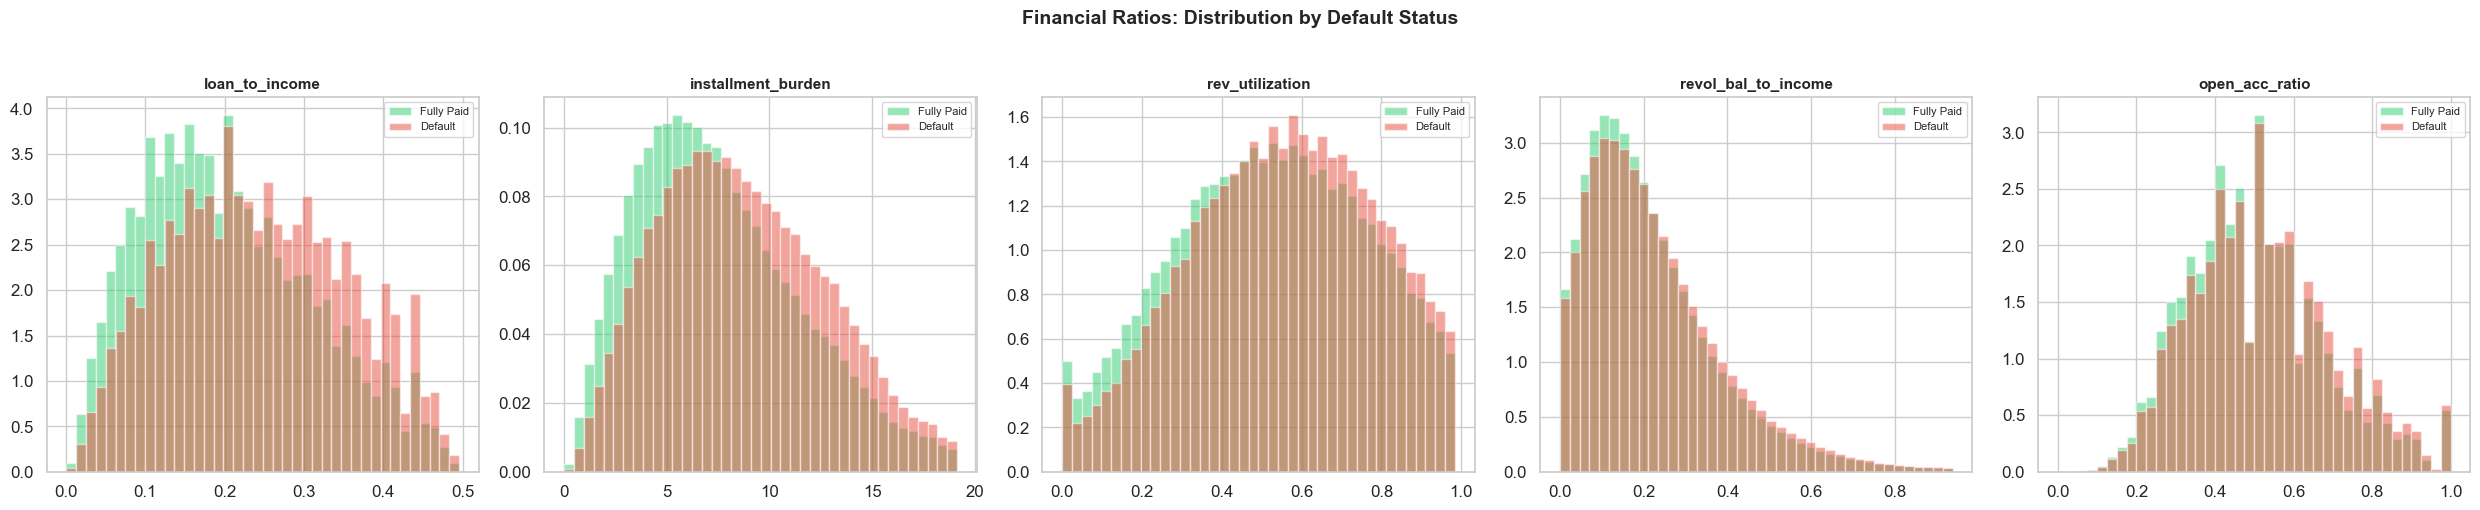

In [5]:
# Visualize ratio features by default status
fig, axes = plt.subplots(1, 5, figsize=(25, 5))
for i, col in enumerate(ratio_cols):
    data = train[[col, "default_flag"]].dropna()
    q99 = data[col].quantile(0.99)
    data = data[data[col] <= q99]
    for flag in [0, 1]:
        subset = data[data["default_flag"] == flag][col]
        axes[i].hist(subset, bins=40, alpha=0.5, density=True,
                     color=["#2ecc71", "#e74c3c"][flag],
                     label=["Fully Paid", "Default"][flag])
    axes[i].set_title(col, fontweight="bold", fontsize=11)
    axes[i].legend(fontsize=8)

fig.suptitle("Financial Ratios: Distribution by Default Status", fontweight="bold", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

---
## 4. Credit History Features

Derived from credit bureau data — these capture the borrower's credit track record.

In [6]:
def create_credit_features(df):
    """Create credit history and bureau-derived features."""
    df = df.copy()

    # FICO mid-point (average of range)
    if "fico_range_low" in df.columns and "fico_range_high" in df.columns:
        df["fico_score"] = (df["fico_range_low"] + df["fico_range_high"]) / 2

    # Credit history length in months
    if "earliest_cr_line" in df.columns and "issue_d" in df.columns:
        df["credit_history_months"] = (
            (pd.to_datetime(df["issue_d"]) - pd.to_datetime(df["earliest_cr_line"])).dt.days / 30.44
        ).clip(lower=0)

    # Credit age in years (more interpretable)
    if "credit_history_months" in df.columns:
        df["credit_age_years"] = df["credit_history_months"] / 12

    # Delinquency flags
    if "delinq_2yrs" in df.columns:
        df["has_delinq_2yrs"] = (df["delinq_2yrs"] > 0).astype(int)

    if "pub_rec" in df.columns:
        df["has_pub_rec"] = (df["pub_rec"] > 0).astype(int)

    if "pub_rec_bankruptcies" in df.columns:
        df["has_bankruptcy"] = (df["pub_rec_bankruptcies"] > 0).astype(int)

    # Days since last delinquency (rename for clarity)
    if "mths_since_last_delinq" in df.columns:
        df["mths_since_delinq"] = df["mths_since_last_delinq"]
        df["delinq_recency"] = df["mths_since_delinq"].fillna(999)  # Never delinquent = far away

    # Recent inquiries (credit-seeking behavior)
    if "inq_last_6mths" in df.columns:
        df["has_recent_inq"] = (df["inq_last_6mths"] > 0).astype(int)
        df["high_inq_flag"] = (df["inq_last_6mths"] >= 3).astype(int)

    # Delinquency severity score
    delinq_cols = ["num_tl_30dpd", "num_tl_90g_dpd_24m", "num_accts_ever_120_pd"]
    available = [c for c in delinq_cols if c in df.columns]
    if available:
        df["delinq_severity"] = df[available].fillna(0).sum(axis=1)

    # Percent of accounts never delinquent (credit reliability)
    if "pct_tl_nvr_dlq" in df.columns:
        df["pct_never_delinq"] = df["pct_tl_nvr_dlq"] / 100.0

    logger.info("Created credit history features")
    return df


train = create_credit_features(train)
cal = create_credit_features(cal)
test = create_credit_features(test)

credit_cols = ["fico_score", "credit_age_years", "has_delinq_2yrs",
               "has_pub_rec", "has_bankruptcy", "delinq_severity"]
train[credit_cols].describe().T.round(2)

2026-02-07 00:18:37.322 | INFO     | __main__:create_credit_features:49 - Created credit history features
2026-02-07 00:18:37.700 | INFO     | __main__:create_credit_features:49 - Created credit history features
2026-02-07 00:18:37.955 | INFO     | __main__:create_credit_features:49 - Created credit history features


,count,mean,std,min,25%,50%,75%,max
fico_score,1346311.0,697.15,30.94,627.0,672.00,692.00,712.00,847.50
credit_age_years,1346311.0,16.41,7.55,3.0,11.25,14.91,20.25,83.25
has_delinq_2yrs,1346311.0,0.20,0.40,0.0,0.00,0.00,0.00,1.00
has_pub_rec,1346311.0,0.17,0.37,0.0,0.00,0.00,0.00,1.00
has_bankruptcy,1346311.0,0.12,0.32,0.0,0.00,0.00,0.00,1.00
delinq_severity,1346311.0,0.57,1.52,0.0,0.00,0.00,0.00,78.00


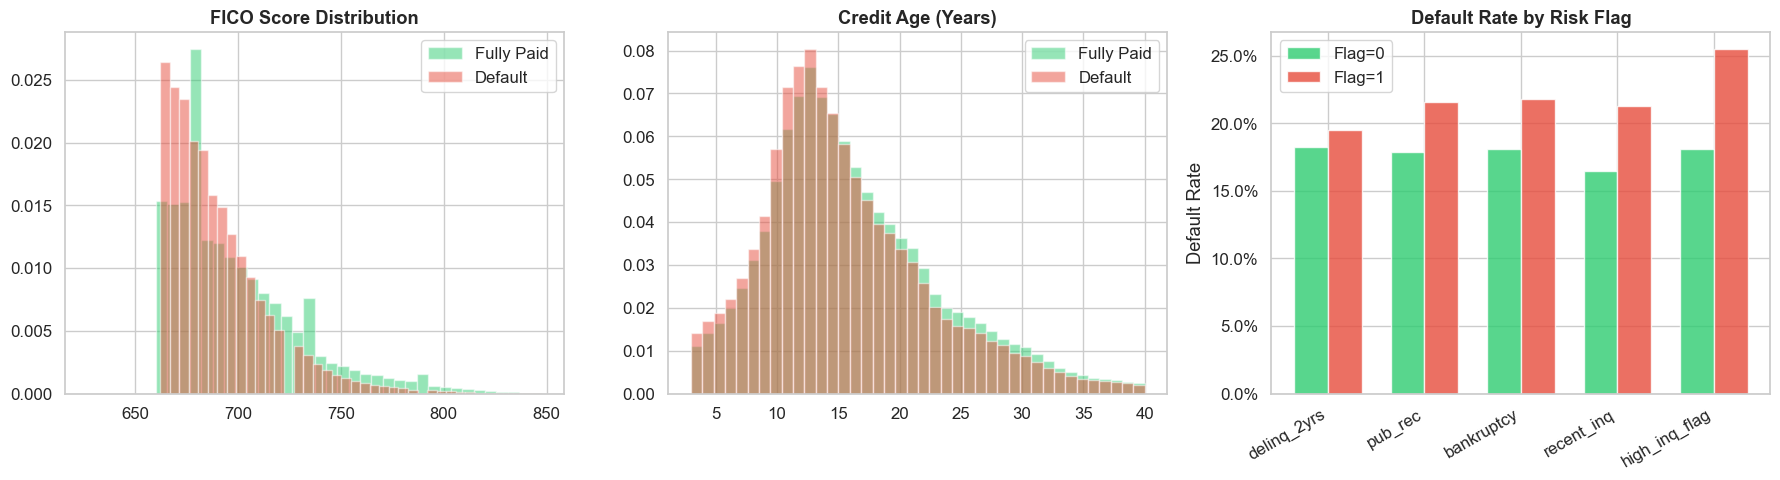

In [7]:
# FICO score by default status
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# FICO distribution
for flag in [0, 1]:
    subset = train[train["default_flag"] == flag]["fico_score"]
    axes[0].hist(subset, bins=40, alpha=0.5, density=True,
                 color=["#2ecc71", "#e74c3c"][flag],
                 label=["Fully Paid", "Default"][flag])
axes[0].set_title("FICO Score Distribution", fontweight="bold")
axes[0].legend()

# Credit age
for flag in [0, 1]:
    subset = train[train["default_flag"] == flag]["credit_age_years"].dropna()
    subset = subset[subset <= 40]
    axes[1].hist(subset, bins=40, alpha=0.5, density=True,
                 color=["#2ecc71", "#e74c3c"][flag],
                 label=["Fully Paid", "Default"][flag])
axes[1].set_title("Credit Age (Years)", fontweight="bold")
axes[1].legend()

# Delinquency flags vs default rate
delinq_flags = ["has_delinq_2yrs", "has_pub_rec", "has_bankruptcy", "has_recent_inq", "high_inq_flag"]
flag_rates = []
for col in delinq_flags:
    for val in [0, 1]:
        rate = train[train[col] == val]["default_flag"].mean()
        flag_rates.append({"feature": col, "value": val, "default_rate": rate})
flag_df = pd.DataFrame(flag_rates)

x = range(len(delinq_flags))
width = 0.35
r0 = flag_df[flag_df["value"] == 0]["default_rate"].values
r1 = flag_df[flag_df["value"] == 1]["default_rate"].values
axes[2].bar([i - width/2 for i in x], r0, width, label="Flag=0", color="#2ecc71", alpha=0.8)
axes[2].bar([i + width/2 for i in x], r1, width, label="Flag=1", color="#e74c3c", alpha=0.8)
axes[2].set_xticks(x)
axes[2].set_xticklabels([c.replace("has_", "") for c in delinq_flags], rotation=30, ha="right")
axes[2].set_ylabel("Default Rate")
axes[2].yaxis.set_major_formatter(mticker.PercentFormatter(1.0))
axes[2].set_title("Default Rate by Risk Flag", fontweight="bold")
axes[2].legend()

plt.tight_layout()
plt.show()

---
## 5. Behavioral & Account Features

Features derived from borrower's existing account behavior — number and type of credit lines, recent account activity.

In [8]:
def create_account_features(df):
    """Create account-level behavioral features."""
    df = df.copy()

    # Installment vs revolving account mix
    if "num_il_tl" in df.columns and "num_rev_accts" in df.columns:
        total_tl = df["num_il_tl"].fillna(0) + df["num_rev_accts"].fillna(0)
        df["il_ratio"] = np.where(total_tl > 0, df["num_il_tl"].fillna(0) / total_tl, 0.5)

    # Active revolving accounts as fraction of total
    if "num_actv_rev_tl" in df.columns and "num_rev_accts" in df.columns:
        df["active_rev_ratio"] = np.where(
            df["num_rev_accts"] > 0,
            df["num_actv_rev_tl"] / df["num_rev_accts"],
            np.nan
        )

    # Recent credit line openings (risk signal: too many = credit seeking)
    if "num_tl_op_past_12m" in df.columns:
        df["many_recent_opens"] = (df["num_tl_op_past_12m"] >= 3).astype(int)

    # Mortgage account flag (stability indicator)
    if "mort_acc" in df.columns:
        df["has_mortgage"] = (df["mort_acc"] > 0).astype(int)

    # Percent of accounts with balance over 75% limit
    if "percent_bc_gt_75" in df.columns:
        df["high_util_pct"] = df["percent_bc_gt_75"] / 100.0

    # Collections/chargeoff within 12 months (recent negative events)
    if "chargeoff_within_12_mths" in df.columns:
        df["recent_chargeoff"] = (df["chargeoff_within_12_mths"] > 0).astype(int)

    if "collections_12_mths_ex_med" in df.columns:
        df["recent_collections"] = (df["collections_12_mths_ex_med"] > 0).astype(int)

    logger.info("Created account features")
    return df


train = create_account_features(train)
cal = create_account_features(cal)
test = create_account_features(test)

acct_cols = ["il_ratio", "active_rev_ratio", "many_recent_opens",
             "has_mortgage", "high_util_pct"]
train[acct_cols].describe().T.round(3)

2026-02-07 00:18:45.171 | INFO     | __main__:create_account_features:37 - Created account features
2026-02-07 00:18:45.509 | INFO     | __main__:create_account_features:37 - Created account features
2026-02-07 00:18:45.733 | INFO     | __main__:create_account_features:37 - Created account features


,count,mean,std,min,25%,50%,75%,max
il_ratio,1346311.0,0.356,0.194,0.0,0.200,0.333,0.500,1.0
active_rev_ratio,1278782.0,0.443,0.213,0.0,0.286,0.417,0.577,1.0
many_recent_opens,1346311.0,0.328,0.470,0.0,0.000,0.000,1.000,1.0
has_mortgage,1346311.0,0.575,0.494,0.0,0.000,1.000,1.000,1.0
high_util_pct,1285609.0,0.469,0.359,0.0,0.143,0.500,0.750,1.0


---
## 6. Bucketing & Interaction Features

Create interpretable buckets and interaction terms for credit risk segmentation.

In [9]:
def create_all_buckets(df):
    """Create bucketed features for risk segmentation."""
    df = df.copy()

    # Interest rate buckets
    if "int_rate" in df.columns:
        df["int_rate_bucket"] = pd.cut(
            df["int_rate"],
            bins=[0, 8, 12, 16, 20, 100],
            labels=["very_low", "low", "medium", "high", "very_high"],
        )

    # DTI buckets
    if "dti" in df.columns:
        df["dti_bucket"] = pd.cut(
            df["dti"],
            bins=[-1, 10, 20, 30, 40, 100],
            labels=["low", "moderate", "high", "very_high", "extreme"],
        )

    # FICO buckets (industry standard)
    if "fico_score" in df.columns:
        df["fico_bucket"] = pd.cut(
            df["fico_score"],
            bins=[0, 660, 700, 740, 780, 900],
            labels=["subprime", "near_prime", "prime", "prime_plus", "super_prime"],
        )

    # Loan amount buckets
    if "loan_amnt" in df.columns:
        df["loan_amnt_bucket"] = pd.cut(
            df["loan_amnt"],
            bins=[0, 5000, 10000, 20000, 30000, 50000],
            labels=["very_small", "small", "medium", "large", "very_large"],
        )

    # Credit age buckets
    if "credit_age_years" in df.columns:
        df["credit_age_bucket"] = pd.cut(
            df["credit_age_years"],
            bins=[0, 5, 10, 15, 20, 100],
            labels=["very_young", "young", "established", "mature", "seasoned"],
        )

    logger.info("Created bucket features")
    return df


def create_all_interactions(df):
    """Create interaction features for risk segmentation."""
    df = df.copy()

    # Grade x Term (key risk interaction)
    if "int_rate_bucket" in df.columns and "grade" in df.columns:
        df["int_rate_bucket__grade"] = (
            df["int_rate_bucket"].astype(str) + "__" + df["grade"].astype(str)
        )

    # Polynomial: loan_to_income squared
    if "loan_to_income" in df.columns:
        df["loan_to_income_sq"] = df["loan_to_income"] ** 2

    # FICO x DTI interaction (combines credit quality with burden)
    if "fico_score" in df.columns and "dti" in df.columns:
        df["fico_x_dti"] = df["fico_score"] * df["dti"]

    # Log transforms for skewed features
    for col in ["annual_inc", "revol_bal", "loan_amnt"]:
        if col in df.columns:
            df[f"log_{col}"] = np.log1p(df[col].clip(lower=0))

    logger.info("Created interaction features")
    return df


train = create_all_buckets(train)
train = create_all_interactions(train)
cal = create_all_buckets(cal)
cal = create_all_interactions(cal)
test = create_all_buckets(test)
test = create_all_interactions(test)

print("Bucket distributions:")
for col in ["int_rate_bucket", "dti_bucket", "fico_bucket", "loan_amnt_bucket"]:
    if col in train.columns:
        print(f"\n{col}:")
        print(train[col].value_counts().sort_index().to_string())

2026-02-07 00:18:47.055 | INFO     | __main__:create_all_buckets:45 - Created bucket features
2026-02-07 00:18:47.875 | INFO     | __main__:create_all_interactions:72 - Created interaction features
2026-02-07 00:18:48.174 | INFO     | __main__:create_all_buckets:45 - Created bucket features
2026-02-07 00:18:48.314 | INFO     | __main__:create_all_interactions:72 - Created interaction features
2026-02-07 00:18:48.510 | INFO     | __main__:create_all_buckets:45 - Created bucket features
2026-02-07 00:18:48.673 | INFO     | __main__:create_all_interactions:72 - Created interaction features


Bucket distributions:

int_rate_bucket:
int_rate_bucket
very_low     202806
low          394764
medium       431437
high         220668
very_high     96636

dti_bucket:
dti_bucket
low          236766
moderate     564413
high         416008
very_high    125109
extreme        3773

fico_bucket:
fico_bucket
subprime            2
near_prime     836527
prime          377080
prime_plus      99108
super_prime     33594

loan_amnt_bucket:
loan_amnt_bucket
very_small    174420
small         368066
medium        506975
large         217124
very_large     79726


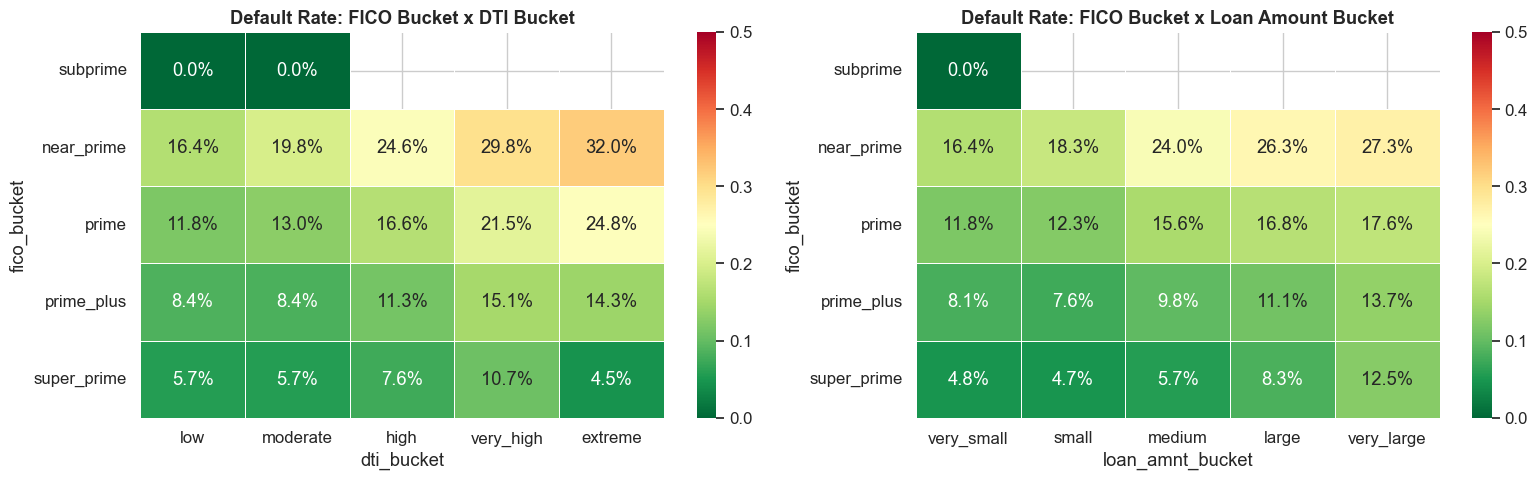

In [10]:
# Default rate by FICO bucket and DTI bucket — heatmap
fico_dti_pivot = train.dropna(subset=["fico_bucket", "dti_bucket"]).pivot_table(
    values="default_flag", index="fico_bucket", columns="dti_bucket", aggfunc="mean"
)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

sns.heatmap(fico_dti_pivot, annot=True, fmt=".1%", cmap="RdYlGn_r",
            linewidths=0.5, ax=axes[0], vmin=0, vmax=0.5)
axes[0].set_title("Default Rate: FICO Bucket x DTI Bucket", fontweight="bold")

# Grade x Term already done in EDA, now add FICO x loan amount
fico_loan_pivot = train.dropna(subset=["fico_bucket", "loan_amnt_bucket"]).pivot_table(
    values="default_flag", index="fico_bucket", columns="loan_amnt_bucket", aggfunc="mean"
)
sns.heatmap(fico_loan_pivot, annot=True, fmt=".1%", cmap="RdYlGn_r",
            linewidths=0.5, ax=axes[1], vmin=0, vmax=0.5)
axes[1].set_title("Default Rate: FICO Bucket x Loan Amount Bucket", fontweight="bold")

plt.tight_layout()
plt.show()

---
## 7. WOE Encoding with OptBinning

**Weight of Evidence (WOE)** transforms categorical and continuous variables into risk-ordered numeric scores. Key benefits for credit scoring:
- Handles non-linear relationships automatically
- Monotonic WOE ensures regulatory compliance
- **Information Value (IV)** provides built-in feature importance

IV interpretation:
| IV Range | Predictive Power |
|----------|-----------------|
| < 0.02 | Useless |
| 0.02 - 0.1 | Weak |
| 0.1 - 0.3 | Medium |
| 0.3 - 0.5 | Strong |
| > 0.5 | Suspicious (check for overfit/leakage) |

In [11]:
from optbinning import OptimalBinning, BinningProcess

# Features to WOE-encode
woe_categorical = ["grade", "sub_grade", "home_ownership", "purpose",
                    "verification_status", "term"]
woe_numerical = ["int_rate", "dti", "annual_inc", "loan_amnt", "fico_score",
                 "installment_burden", "rev_utilization", "credit_age_years",
                 "open_acc", "total_acc", "revol_bal", "pub_rec",
                 "inq_last_6mths", "emp_length_num"]

# Fit WOE on training data only (avoid leakage)
woe_results = {}
iv_scores = {}
train_target = train["default_flag"].values

print("Computing WOE encodings...\n")
print(f"{'Feature':30s} {'Type':12s} {'IV':>8s}  {'Bins':>5s}  Status")
print("-" * 75)

for col in woe_categorical + woe_numerical:
    if col not in train.columns:
        print(f"{col:30s} {'skip':12s} {'N/A':>8s}  {'N/A':>5s}  Column not found")
        continue

    dtype = "categorical" if col in woe_categorical else "numerical"
    try:
        optb = OptimalBinning(
            name=col,
            dtype=dtype,
            solver="cp",
            monotonic_trend="auto",
            min_bin_size=0.02,
        )

        x_vals = train[col].values
        if dtype == "numerical":
            x_vals = pd.to_numeric(pd.Series(x_vals), errors="coerce").values

        optb.fit(x_vals, train_target)

        # Get IV
        bt = optb.binning_table.build()
        iv = bt["IV"].values
        total_iv = iv[:-2].sum() if len(iv) > 2 else iv.sum()
        n_bins = len(bt) - 2  # exclude Totals and Special

        woe_results[col] = optb
        iv_scores[col] = total_iv

        status = "OK"
        if total_iv > 0.5:
            status = "WARNING: high IV"
        elif total_iv < 0.02:
            status = "Weak predictor"

        print(f"{col:30s} {dtype:12s} {total_iv:8.4f}  {n_bins:5d}  {status}")

    except Exception as e:
        print(f"{col:30s} {dtype:12s} {'ERROR':>8s}  {'---':>5s}  {str(e)[:40]}")

Computing WOE encodings...

Feature                        Type               IV   Bins  Status
---------------------------------------------------------------------------
grade                          categorical    0.4497      6  OK
sub_grade                      categorical    0.4820     16  OK
home_ownership                 categorical    0.0247      4  OK
purpose                        categorical    0.0161      5  Weak predictor
verification_status            categorical    0.0477      4  OK
term                           categorical    0.1827      3  OK
int_rate                       numerical      0.4610     16  OK
dti                            numerical      0.0643     15  OK
annual_inc                     numerical      0.0278     14  OK
loan_amnt                      numerical      0.0349      9  OK
fico_score                     numerical      0.1171     14  OK
installment_burden             numerical      0.0889     15  OK
rev_utilization                numerical      0.

In [12]:
# Show binning tables for top 3 WOE features
top_woe = sorted(iv_scores, key=iv_scores.get, reverse=True)[:3]

for col in top_woe:
    optb = woe_results[col]
    print(f"\n{'='*60}")
    print(f"Binning Table: {col} (IV = {iv_scores[col]:.4f})")
    print(f"{'='*60}")
    bt = optb.binning_table.build()
    print(bt.to_string())


Binning Table: sub_grade (IV = 0.4820)
                                                     Bin    Count  Count (%)  Non-event   Event  Event rate       WoE        IV        JS
0                                               [A1, A2]    80334   0.059670      77447    2887    0.035937  1.808082  0.106725  0.011777
1                                               [A3, A4]    86470   0.064227      81335    5135    0.059385  1.281203  0.068617  0.008035
2                                               [A5, B1]   135637   0.100747     123824   11813    0.087093  0.868367  0.056889  0.006896
3                                                   [B2]    74326   0.055207      66496    7830    0.105347  0.657886  0.019225  0.002361
4                                                   [B3]    83362   0.061919      73406    9956    0.119431  0.516537  0.013945  0.001724
5                                                   [B4]    86085   0.063941      74295   11790    0.136958  0.359498  0.007353  0.0

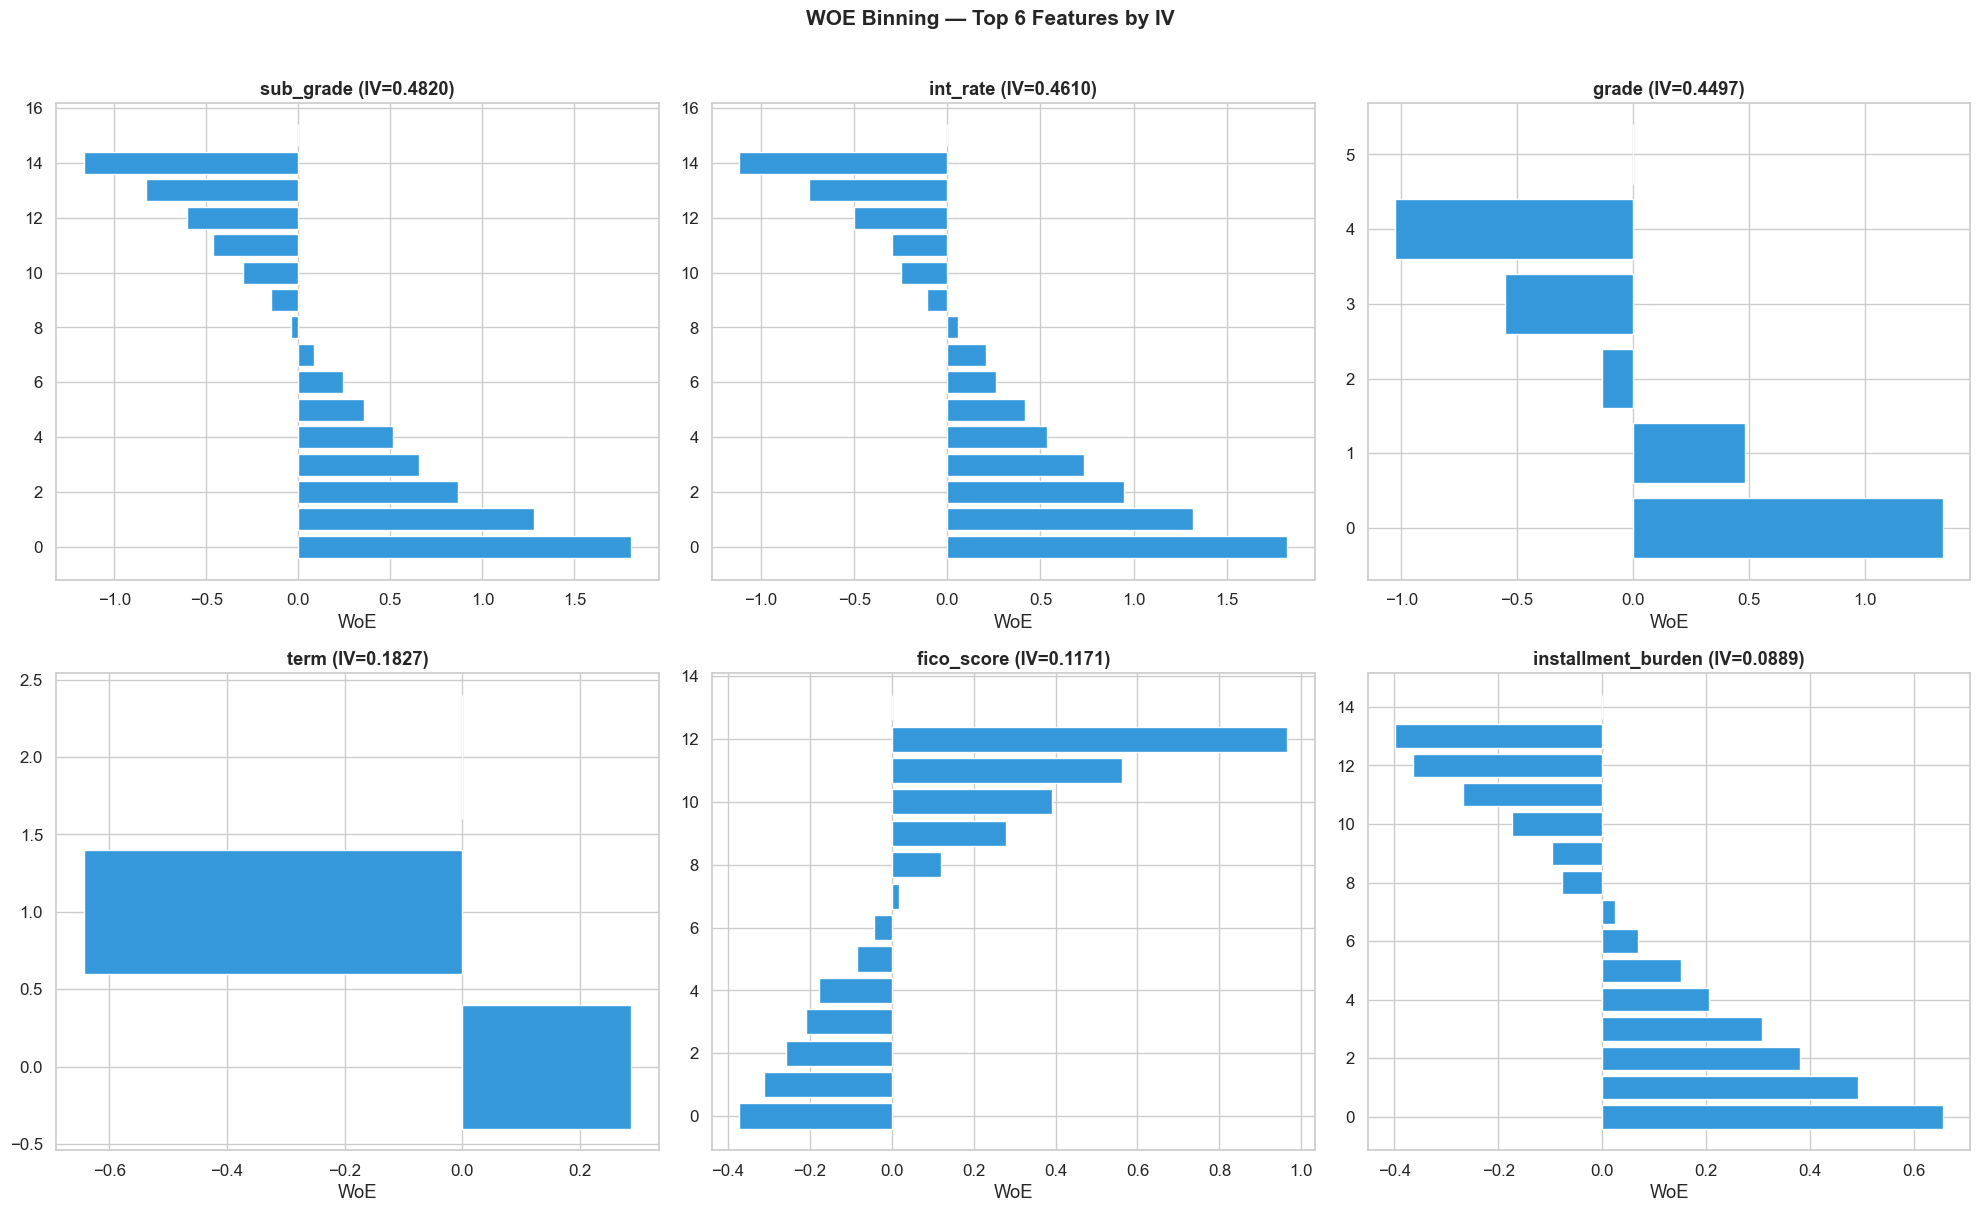

In [13]:
# Visualize binning tables for top features
top6 = sorted(iv_scores, key=iv_scores.get, reverse=True)[:6]
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.ravel()

for i, col in enumerate(top6):
    optb = woe_results[col]
    try:
        optb.binning_table.plot(metric="woe", ax=axes[i])
        axes[i].set_title(f"{col}\n(IV={iv_scores[col]:.4f})", fontweight="bold")
    except Exception:
        bt = optb.binning_table.build()
        woe_vals = bt["WoE"].values[:-2]
        axes[i].barh(range(len(woe_vals)), woe_vals, color="#3498db")
        axes[i].set_title(f"{col} (IV={iv_scores[col]:.4f})", fontweight="bold")
        axes[i].set_xlabel("WoE")

plt.suptitle("WOE Binning — Top 6 Features by IV", fontweight="bold", fontsize=15, y=1.01)
plt.tight_layout()
plt.show()

In [14]:
# Apply WOE transformation to all datasets
def apply_woe_transform(df, woe_results):
    """Apply fitted WOE encoders to a DataFrame."""
    df = df.copy()
    for col, optb in woe_results.items():
        try:
            dtype = "categorical" if optb.dtype == "categorical" else "numerical"
            x_vals = df[col].values
            if dtype == "numerical":
                x_vals = pd.to_numeric(pd.Series(x_vals), errors="coerce").values
            df[f"{col}_woe"] = optb.transform(x_vals, metric="woe")
        except Exception as e:
            logger.warning(f"WOE transform failed for {col}: {e}")
    return df

train = apply_woe_transform(train, woe_results)
cal = apply_woe_transform(cal, woe_results)
test = apply_woe_transform(test, woe_results)

woe_cols = [c for c in train.columns if c.endswith("_woe")]
print(f"WOE columns created: {len(woe_cols)}")
print(woe_cols)

WOE columns created: 20
['grade_woe', 'sub_grade_woe', 'home_ownership_woe', 'purpose_woe', 'verification_status_woe', 'term_woe', 'int_rate_woe', 'dti_woe', 'annual_inc_woe', 'loan_amnt_woe', 'fico_score_woe', 'installment_burden_woe', 'rev_utilization_woe', 'credit_age_years_woe', 'open_acc_woe', 'total_acc_woe', 'revol_bal_woe', 'pub_rec_woe', 'inq_last_6mths_woe', 'emp_length_num_woe']


---
## 8. Information Value (IV) Ranking

IV summarizes the predictive power of each feature. We use it to select the most discriminative features for modeling.

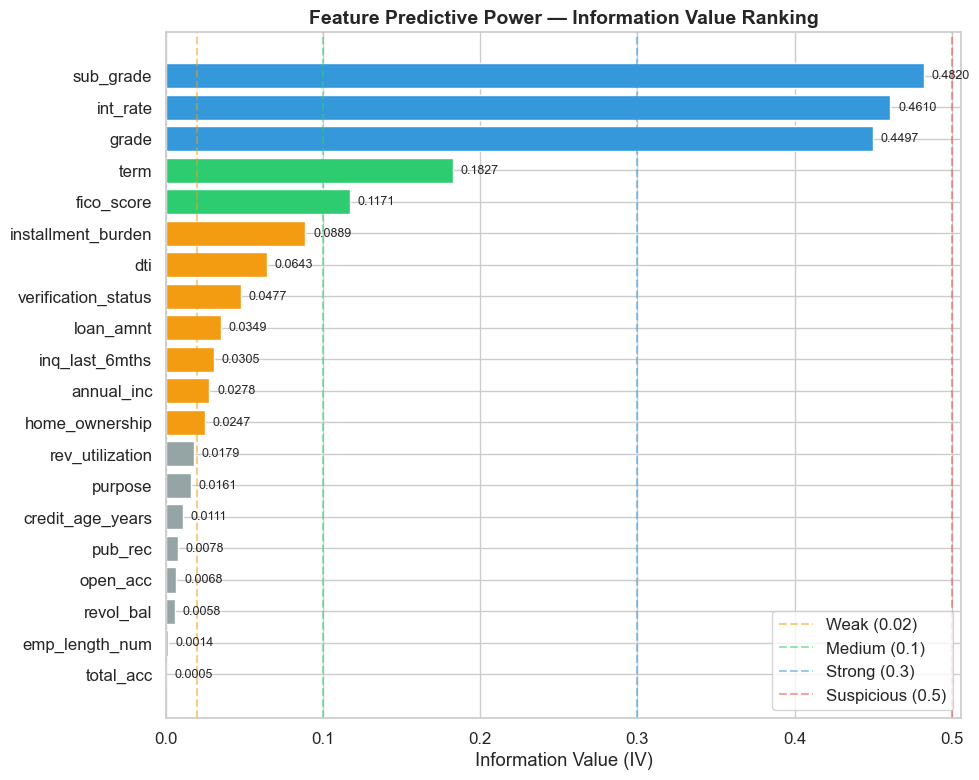


IV Summary by Strength Category:
          count   mean_iv    max_iv
strength                           
Useless       8  0.008432  0.017884
Weak          7  0.045552  0.088902
Medium        2  0.149897  0.182666
Strong        3  0.464230  0.481995


In [15]:
# IV ranking visualization
iv_df = (
    pd.DataFrame.from_dict(iv_scores, orient="index", columns=["IV"])
    .sort_values("IV", ascending=True)
)

# Categorize IV strength
iv_df["strength"] = pd.cut(
    iv_df["IV"],
    bins=[-np.inf, 0.02, 0.1, 0.3, 0.5, np.inf],
    labels=["Useless", "Weak", "Medium", "Strong", "Suspicious"]
)

color_map = {"Useless": "#95a5a6", "Weak": "#f39c12", "Medium": "#2ecc71",
             "Strong": "#3498db", "Suspicious": "#e74c3c"}
colors = [color_map[s] for s in iv_df["strength"]]

fig, ax = plt.subplots(figsize=(10, max(8, len(iv_df) * 0.35)))
bars = ax.barh(iv_df.index, iv_df["IV"], color=colors, edgecolor="white")

for bar, iv_val in zip(bars, iv_df["IV"]):
    ax.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
            f"{iv_val:.4f}", va="center", fontsize=9)

# Threshold lines
ax.axvline(0.02, color="#f39c12", ls="--", alpha=0.5, label="Weak (0.02)")
ax.axvline(0.1, color="#2ecc71", ls="--", alpha=0.5, label="Medium (0.1)")
ax.axvline(0.3, color="#3498db", ls="--", alpha=0.5, label="Strong (0.3)")
ax.axvline(0.5, color="#e74c3c", ls="--", alpha=0.5, label="Suspicious (0.5)")

ax.set_xlabel("Information Value (IV)")
ax.set_title("Feature Predictive Power — Information Value Ranking", fontweight="bold", fontsize=14)
ax.legend(loc="lower right")
plt.tight_layout()
plt.show()

# Summary table
print("\nIV Summary by Strength Category:")
print(iv_df.groupby("strength", observed=True).agg(count=("IV", "size"), mean_iv=("IV", "mean"), max_iv=("IV", "max")).to_string())

---
## 9. Feature Selection — Final Modeling Set

Select features based on:
1. IV > 0.02 (at least weak predictive power)
2. No data leakage (only pre-origination variables)
3. Manageable null rates (< 50% or handled by CatBoost)
4. No redundant features (remove high-correlation pairs)

In [16]:
# Define final feature sets
# Numeric features (for CatBoost — handles NaN natively)
NUMERIC_FEATURES = [
    # Core financial
    "loan_amnt", "int_rate", "installment", "annual_inc", "dti",
    # Ratios
    "loan_to_income", "installment_burden", "rev_utilization",
    "revol_bal_to_income", "open_acc_ratio",
    # Credit history
    "fico_score", "credit_age_years", "emp_length_num",
    # Bureau counts
    "open_acc", "total_acc", "revol_bal", "pub_rec",
    "inq_last_6mths", "mort_acc",
    # Delinquency
    "delinq_severity", "delinq_recency",
    # Account behavior
    "il_ratio", "high_util_pct",
    # Transforms
    "log_annual_inc", "log_revol_bal",
    "loan_to_income_sq", "fico_x_dti",
]

# Binary flags
FLAG_FEATURES = [
    "has_delinq_2yrs", "has_pub_rec", "has_bankruptcy",
    "has_recent_inq", "has_mortgage", "many_recent_opens",
    "recent_chargeoff",
]

# Categorical features (for CatBoost cat_features)
CATEGORICAL_FEATURES = [
    "grade", "sub_grade", "home_ownership", "purpose",
    "verification_status", "term",
    "int_rate_bucket", "dti_bucket", "fico_bucket",
]

# WOE features (for LogReg — no categoricals needed)
WOE_FEATURES = [c for c in woe_cols if iv_scores.get(c.replace("_woe", ""), 0) > 0.02]

# Interaction features
INTERACTION_FEATURES = ["int_rate_bucket__grade"]

# Filter to only features that exist
def filter_existing(cols, df):
    return [c for c in cols if c in df.columns]

num_feat = filter_existing(NUMERIC_FEATURES, train)
flag_feat = filter_existing(FLAG_FEATURES, train)
cat_feat = filter_existing(CATEGORICAL_FEATURES, train)
woe_feat = filter_existing(WOE_FEATURES, train)
int_feat = filter_existing(INTERACTION_FEATURES, train)

print("Feature set sizes:")
print(f"  Numeric:      {len(num_feat)}")
print(f"  Flags:        {len(flag_feat)}")
print(f"  Categorical:  {len(cat_feat)}")
print(f"  WOE:          {len(woe_feat)}")
print(f"  Interactions: {len(int_feat)}")

# CatBoost model features
CATBOOST_FEATURES = num_feat + flag_feat + cat_feat + int_feat
# LogReg model features (WOE-encoded, no categoricals)
LOGREG_FEATURES = num_feat + flag_feat + woe_feat

print(f"\nCatBoost total: {len(CATBOOST_FEATURES)} features")
print(f"LogReg total:   {len(LOGREG_FEATURES)} features")

Feature set sizes:
  Numeric:      27
  Flags:        7
  Categorical:  9
  WOE:          12
  Interactions: 1

CatBoost total: 44 features
LogReg total:   46 features


In [17]:
# Check null rates in final feature set
null_analysis = []
for col in CATBOOST_FEATURES:
    null_pct = train[col].isnull().mean() * 100
    null_analysis.append({"feature": col, "null_pct": null_pct,
                         "type": "categorical" if col in cat_feat else "numeric"})

null_df = pd.DataFrame(null_analysis).sort_values("null_pct", ascending=False)
print("Features with >1% nulls (CatBoost handles natively):")
print(null_df[null_df["null_pct"] > 1].to_string(index=False))

Features with >1% nulls (CatBoost handles natively):
       feature  null_pct    type
emp_length_num  5.667264 numeric
 high_util_pct  4.508765 numeric
      mort_acc  3.511893 numeric


In [18]:
# Correlation check for multicollinearity among numeric features
corr = train[num_feat].corr().abs()
# Find highly correlated pairs (>0.85)
high_corr_pairs = []
for i in range(len(corr.columns)):
    for j in range(i+1, len(corr.columns)):
        if corr.iloc[i, j] > 0.85:
            high_corr_pairs.append({
                "feature_1": corr.columns[i],
                "feature_2": corr.columns[j],
                "correlation": corr.iloc[i, j]
            })

if high_corr_pairs:
    print("Highly correlated feature pairs (|r| > 0.85):")
    for pair in sorted(high_corr_pairs, key=lambda x: x["correlation"], reverse=True):
        print(f"  {pair['feature_1']:25s} <-> {pair['feature_2']:25s}  r={pair['correlation']:.3f}")
    print("\nNote: CatBoost is robust to multicollinearity. For LogReg, consider dropping one from each pair.")
else:
    print("No feature pairs with |r| > 0.85 found.")

Highly correlated feature pairs (|r| > 0.85):
  loan_to_income            <-> installment_burden         r=0.997
  dti                       <-> fico_x_dti                 r=0.996
  installment_burden        <-> loan_to_income_sq          r=0.971
  loan_to_income            <-> loan_to_income_sq          r=0.967
  loan_amnt                 <-> installment                r=0.951
  revol_bal_to_income       <-> loan_to_income_sq          r=0.942
  installment_burden        <-> revol_bal_to_income        r=0.879
  loan_to_income            <-> revol_bal_to_income        r=0.867

Note: CatBoost is robust to multicollinearity. For LogReg, consider dropping one from each pair.


---
## 10. Save Modeling-Ready Datasets

Save feature-engineered datasets with the selected feature columns + target + metadata.

In [19]:
# Columns to keep for modeling
keep_cols = list(set(
    CATBOOST_FEATURES + LOGREG_FEATURES +
    ["default_flag", "issue_d", "loan_status", "id"]
))
keep_cols = [c for c in keep_cols if c in train.columns]

train_fe = train[keep_cols].copy()
cal_fe = cal[keep_cols].copy()
test_fe = test[keep_cols].copy()

print(f"Feature-engineered datasets:")
print(f"  Train:       {train_fe.shape}")
print(f"  Calibration: {cal_fe.shape}")
print(f"  Test:        {test_fe.shape}")

# Save
output_dir = DATA_DIR
train_fe.to_parquet(output_dir / "train_fe.parquet", index=False)
cal_fe.to_parquet(output_dir / "calibration_fe.parquet", index=False)
test_fe.to_parquet(output_dir / "test_fe.parquet", index=False)

print(f"\nSaved to {output_dir}:")
print(f"  train_fe.parquet        ({train_fe.shape[0]:,} x {train_fe.shape[1]})")
print(f"  calibration_fe.parquet  ({cal_fe.shape[0]:,} x {cal_fe.shape[1]})")
print(f"  test_fe.parquet         ({test_fe.shape[0]:,} x {test_fe.shape[1]})")

Feature-engineered datasets:
  Train:       (1346311, 60)
  Calibration: (237584, 60)
  Test:        (276869, 60)

Saved to ..\data\processed:
  train_fe.parquet        (1,346,311 x 60)
  calibration_fe.parquet  (237,584 x 60)
  test_fe.parquet         (276,869 x 60)


In [20]:
# Save feature lists and WOE encoders for later use
import pickle

feature_config = {
    "NUMERIC_FEATURES": num_feat,
    "FLAG_FEATURES": flag_feat,
    "CATEGORICAL_FEATURES": cat_feat,
    "WOE_FEATURES": woe_feat,
    "INTERACTION_FEATURES": int_feat,
    "CATBOOST_FEATURES": CATBOOST_FEATURES,
    "LOGREG_FEATURES": LOGREG_FEATURES,
    "iv_scores": iv_scores,
}

# Save feature config
config_path = output_dir / "feature_config.pkl"
with open(config_path, "wb") as f:
    pickle.dump(feature_config, f)
print(f"Feature config saved to {config_path}")

# Save WOE encoders
woe_path = output_dir / "woe_encoders.pkl"
with open(woe_path, "wb") as f:
    pickle.dump(woe_results, f)
print(f"WOE encoders saved to {woe_path}")

Feature config saved to ..\data\processed\feature_config.pkl
WOE encoders saved to ..\data\processed\woe_encoders.pkl


In [21]:
# Validate with Pandera schema
from src.features.schemas import loan_master_schema

try:
    loan_master_schema.validate(train_fe, lazy=True)
    print("Pandera validation PASSED for train_fe")
except Exception as e:
    print(f"Pandera validation issues (non-blocking):\n{e}")

# Final summary
print(f"\n{'='*60}")
print("FEATURE ENGINEERING COMPLETE")
print(f"{'='*60}")
print(f"Total features: {len(keep_cols) - 3} (excluding id, issue_d, loan_status)")
print(f"WOE features: {len(woe_feat)} (IV > 0.02)")
print(f"IV range: [{min(iv_scores.values()):.4f}, {max(iv_scores.values()):.4f}]")
print(f"Top 5 features by IV:")
for col in sorted(iv_scores, key=iv_scores.get, reverse=True)[:5]:
    print(f"  {col:30s} IV={iv_scores[col]:.4f}")

Pandera validation issues (non-blocking):
{
    "DATA": {
        "DATAFRAME_CHECK": [
            {
                "schema": null,
                "column": "annual_inc",
                "check": "greater_than(0)",
                "error": "Column 'annual_inc' failed element-wise validator number 0: greater_than(0) failure cases: 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0"
            },
            {
                "schema": null,
                "column": "loan_to_income",
                "check": "in_range(0, 100)",
                "error": "Column 'loan_to_income' failed element-wise validator number 0: in_range(0, 100) failure cases: 24000.0, 18000.0, 24000.0, 2400.0, 15000.0, 35000.0"
 

---
## 11. Summary

### Features Created

| Category | Count | Examples |
|----------|-------|---------|
| Financial Ratios | 6+ | loan_to_income, installment_burden, rev_utilization, revol_bal_to_income |
| Credit History | 8+ | fico_score, credit_age_years, delinq_severity, delinq_recency |
| Binary Flags | 7 | has_delinq_2yrs, has_bankruptcy, has_mortgage, high_inq_flag |
| Account Behavior | 5+ | il_ratio, active_rev_ratio, high_util_pct |
| Buckets | 5 | int_rate_bucket, dti_bucket, fico_bucket, loan_amnt_bucket, credit_age_bucket |
| WOE Encoded | 14+ | grade_woe, purpose_woe, int_rate_woe, fico_score_woe |
| Interactions | 3 | int_rate_bucket__grade, loan_to_income_sq, fico_x_dti |
| Log Transforms | 3 | log_annual_inc, log_revol_bal, log_loan_amnt |

### Key Decisions
- **WOE fitted on training set only** — prevents data leakage
- **Two feature sets**: CatBoost (raw categoricals) vs LogReg (WOE-encoded)
- **No imputation for CatBoost** — handles NaN natively
- **emp_length parsed to numeric** — enables continuous modeling
- **FICO mid-point** — combines low/high range for single score

### Artifacts Saved
- `train_fe.parquet`, `calibration_fe.parquet`, `test_fe.parquet` — modeling-ready
- `feature_config.pkl` — feature lists and IV scores
- `woe_encoders.pkl` — fitted OptBinning objects for production scoring

### Next Steps
1. **Notebook 03**: PD Modeling — LogReg baseline + CatBoost + Optuna HPO
2. **Notebook 04**: Conformal Prediction — MAPIE intervals with coverage validation

## Final Conclusions: Feature Engineering

### Key Findings
- Engineered features add economically meaningful structure (ratios, buckets, interactions, temporal proxies).
- WOE-style transformations improve monotonic interpretability for risk-driven variables.
- Feature set design balances predictive signal with governance-friendly explainability.

### Financial Risk Interpretation
- Borrower affordability, utilization, and delinquency history act as consistent risk amplifiers.
- Structured bins and interactions convert noisy raw fields into stable risk gradients.
- Feature transparency supports policy setting, auditability, and model-risk review.

### Contribution to End-to-End Pipeline
- Produces `train_fe`, `calibration_fe`, and `test_fe`, the canonical modeling inputs.
- Enables stable PD training, calibration, conformal uncertainty estimation, and optimization constraints.
- Anchors reproducibility through `feature_config.pkl` so every stage uses the same contract.